<a href="https://www.kaggle.com/code/shreyasdomde/weather-detection?scriptVersionId=166135518" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Test Version of Exported Weather Models

In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, callbacks 


import warnings
warnings.filterwarnings("ignore")

In [3]:
# defining hyperparameters
height, width = 150, 150

In [4]:
class Model_builder:
    
    def __init__(self, pretrained_model):
        self.model = self.build_model(pretrained_model)
    
    def build_model(self, pretrained_model):

        for layer in pretrained_model.layers:
            layer.trainable = False

        model = tf.keras.Sequential()
        model.add(layers.Resizing(height, width))
        model.add(layers.Rescaling(1/255.0))
        model.add(pretrained_model)

        model.add(layers.Flatten())
        model.add(layers.Dense(units=256, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())

        model.add(layers.Dense(units=11, activation='softmax'))
        
        return model
    
    def compile_model(self, opt):
        self.model.compile(
            optimizer = opt,
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )
    
    def model_summary(self):
        self.model.build((None, height, width, 3))
        self.model.summary()
        
    def get_model(self):
        return self.model
    

In [5]:
# 🔵🔵🔵

wights = {
     'vgg16':'imagenet',
     'resnet50':'imagenet',
     'xception':'imagenet'
}

In [6]:
xception_pretrained = tf.keras.applications.Xception(weights=wights['xception'], include_top=False, input_shape=(height, width, 3))
xception_model = Model_builder(xception_pretrained)
xception_model.compile_model('adam')
xception_model.model_summary()
model = xception_model.get_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,972,787 (129.60 MB)

 Trainable params: 13,110,795 (50.01 MB)

 Non-trainable params: 20,861,992 (79.58 MB)

In [7]:
# model = Model_Loader().build_model()

model.load_weights('./models/xception_weights.h5')

# # Compile the model (optional, depending on your use case)
# model.compile(
#     optimizer='adam', 
#     loss='categorical_crossentropy', 
#     metrics=['accuracy']
# )

# 🐉Predicting Images of test data

In [8]:
# 🔴🔴🔴
datadir = './dataset'

In [9]:
climates = {cl: len(os.listdir(os.path.join(datadir, cl))) for cl in os.listdir(datadir)}

<Axes: >

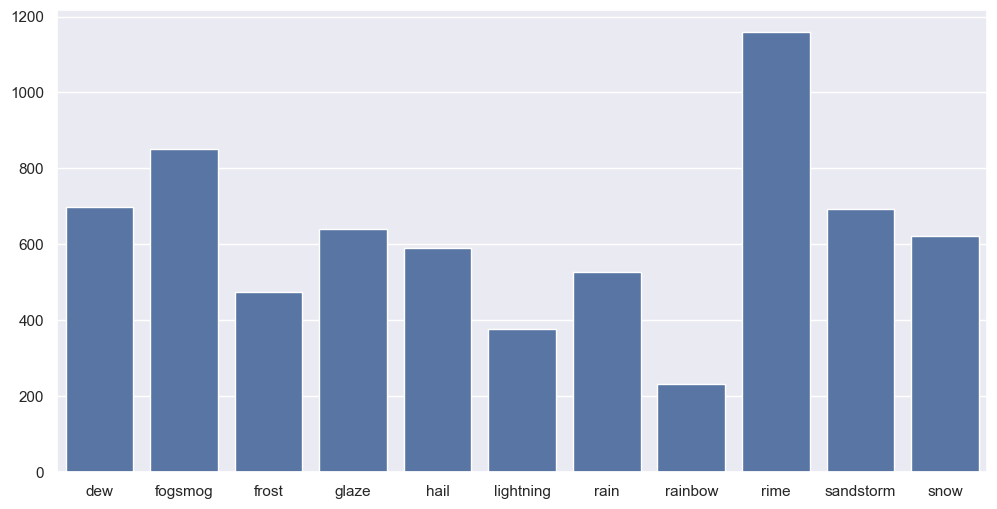

In [10]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.barplot(x=list(climates.keys()), y=list(climates.values()))

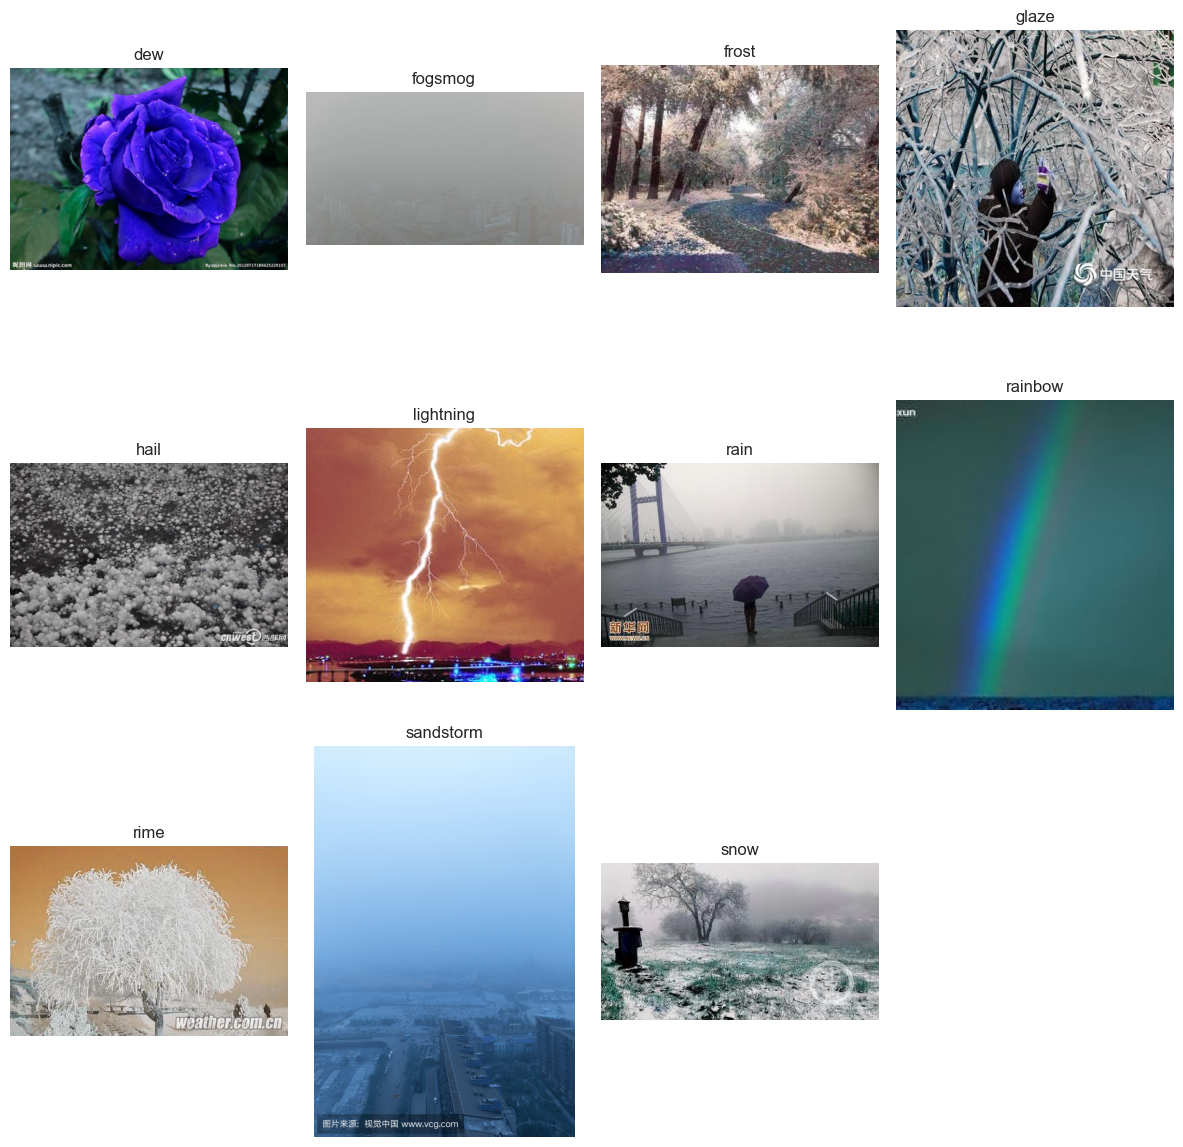

In [11]:
fig = plt.figure(figsize=(12, 12)) 
rows = 3
columns = 4

for i, cl in enumerate(climates.keys()):
    img_name = os.listdir(os.path.join(datadir, cl))[random.randrange(0, 100)]
    img_path = os.path.join(datadir, cl, img_name)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(img)
    plt.title(cl)
    
plt.tight_layout()
plt.show()

In [12]:
filepaths = []
labels = []
for i in climates.keys():
    img_path = datadir+'/'+i
    for imgs in os.listdir(img_path):
        filepaths.append(os.path.join(img_path, imgs))
        labels.append(i)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=44) 

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.2
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [15]:
train_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training'
)

val_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset='validation'
)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.


In [31]:
test_data = train_datagen.flow_from_dataframe(
    df_test, 
    x_col = 'filepaths',
    y_col = 'labels',
    color_mode = 'rgb',
    batch_size = 64,
)

Found 1373 validated image filenames belonging to 11 classes.


In [27]:
# i want to evaluate the model
model.evaluate(test_data)

687/687 ━━━━━━━━━━━━━━━━━━━━ 107s 156ms/step - accuracy: 0.9189 - loss: 0.2915


[0.2908339202404022, 0.9111434817314148]

In [19]:
# y_pred = vgg_model.predict(test_data)
y_pred = model.predict(test_data)
y_pred

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 100s 71ms/step


array([[9.9793530e-01, 2.4628095e-08, 1.4529255e-05, ..., 6.0374072e-07,
        5.5927325e-07, 1.5858055e-06],
       [3.0794508e-06, 3.4722458e-08, 5.8706974e-07, ..., 8.0354592e-05,
        3.3595818e-05, 9.9624711e-01],
       [3.6021040e-06, 9.7303629e-01, 6.1649394e-06, ..., 4.8889115e-06,
        2.6654277e-02, 8.7551625e-06],
       ...,
       [2.4896816e-03, 3.3972531e-03, 8.4264921e-03, ..., 2.2497815e-03,
        4.2646144e-02, 7.1442887e-02],
       [4.1635400e-07, 7.1140209e-07, 3.0075120e-09, ..., 4.6608011e-09,
        9.9998820e-01, 1.7608745e-08],
       [3.1910335e-05, 1.0379837e-05, 2.0042683e-03, ..., 9.9765623e-01,
        2.5310649e-07, 1.0376940e-04]], dtype=float32)

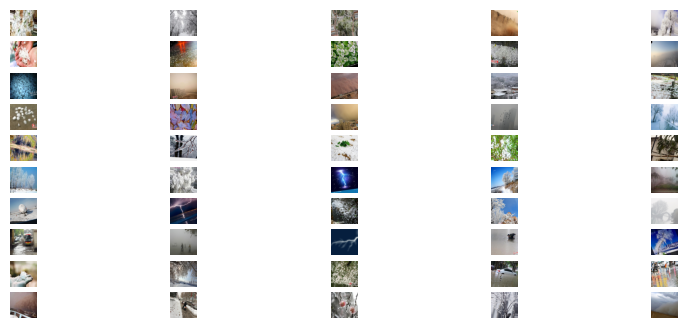

In [22]:
# Normalize the images to [0, 1] range
normalized_images = test_data[0][0] / 255.0

fig, axes = plt.subplots(10, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(normalized_images[i])
    ax.axis('off')  # to hide the axis

plt.show()

In [ ]:
classes = {val:key for key, val in test_data.class_indices.items()}

def vis_pred(ind):
    rows, columns = 3, 4
    x, y = next(iter(test_data))
    fig = plt.figure(figsize=(10, 10))
    for i in range(rows * columns):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(x[ind+i] / 255)
        plt.title(f'Original: {classes[np.argmax(y[ind + i])]} \nPredicted: {classes[np.argmax(y_pred[ind + i])]}')
        print(f'Original: {classes[np.argmax(y[ind + i])]} \nPredicted: {classes[np.argmax(y_pred[ind + i])]} \npredictions: {y_pred[ind + i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
vis_pred(10)